# notebook-001-1
*This notebook was run on macOS Catalina (Version 10.15.4) with the following specs:*

    * Processor: 2.7 GHz Dual-Core Intel Core i5
    * Memory: 8 GB 1867 MHz DDR3

Here we will demonstrate an example of running histology image processing on the H&E imaging modality. We will be using the prostate H&E imaging data from prototype-001 in the MIAAIM software.

First import the necessary modules.

In [1]:
import sys
sys.version

'3.7.2 (v3.7.2:9a3ffc0492, Dec 24 2018, 02:44:43) \n[Clang 6.0 (clang-600.0.57)]'

In [2]:
# import hdi utils module
import hdiutils.HDIimport.hdi_reader as hdi_reader
# import hdi_prep module
from miaaim.hdiprep.HDIprep import hdi_prep
# import external modules
import matplotlib.pyplot as plt
import os

Now we will set the path to our imaging data and the output folders, and we will read in the imaging data set using the `HDIreader` class from the hdi-utils python package. We will then create a dataset using the `HDIprep` module imported above.

In [3]:
# set the path to the imaging data
path_to_im = "/Users/joshuahess/Desktop/prototype-001/input/fixed"
# set the path to the output directory
out_path = "/Users/joshuahess/Desktop/prototype-001/notebook-output"

# read data with HDIutils
fix_im = hdi_reader.HDIreader(
                    path_to_data=path_to_im,
                    path_to_markers=None,
                    flatten=False,
                    subsample=None,
                    mask=True,
                    save_mem=False
                    )
# create data set using HDIprep module
fix_dat = hdi_prep.IntraModalityDataset([fix_im])
# for plotting purposes, extract the key of the data set
key = list(fix_dat.set_dict.keys())[0]

mask: /Users/joshuahess/Desktop/prototype-001/input/fixed/fixed-mask.tif
Valid path...
Valid file extension... 
file name: /Users/joshuahess/Desktop/prototype-001/input/fixed/fixed.tif 
parsing cytometry data...
Finished parsing image data


Now use the `IntramodalityDataset` class to run sequential morphological operations. Here we will show the input H&E image along with the manually drawn mask that we will use to help our image processing pipeline.

**Note that all data are stored in the `IntramodalityDataset` as dictionary objects, kept under their filename as the key**

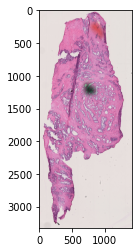

In [4]:
# plot the histology image
plt.imshow(fix_dat.set_dict[key].hdi.data.image)

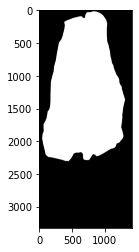

In [5]:
# plot the input manually drawn mask in ImageJ
plt.imshow(fix_dat.set_dict[key].hdi.data.mask.toarray(),cmap='gray')

Next, we will convert the image to grayscale (carried out automatically in the `MedianFilter` function) and will use a median filter to remove salt and pepper noise in the image prior to the thresholding process.

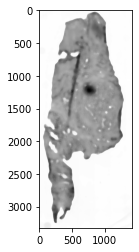

In [6]:
# apply sequential processing steps
# remove salt and pepper noise
fix_dat.MedianFilter(filter_size=25,parallel=False)
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image,cmap='gray')

After filtering, we will use the `otsu` automatic thresholding method to convert the grayscale image into a binary mask separating foreground from background.

/Users/joshuahess/Desktop/miaaim/miaaim-python/miaaim/hdiprep/HDIprep/morphology.py:64: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = skimage.color.rgb2gray(image)


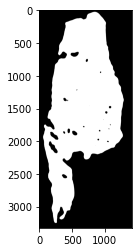

In [7]:
# create mask with thresholding
fix_dat.Threshold(type='otsu')
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

After thresholding, we will perform a series of morphological operations on the mask to smooth edges, fill holes, and connect regions in the mask that should represent the foreground (where the tissue is).

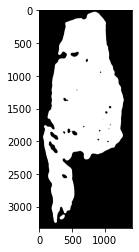

In [8]:
# morphological opening
fix_dat.Open(disk_size=20,parallel=False)
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

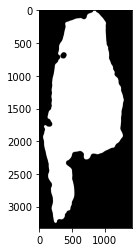

In [9]:
# morphological closing
fix_dat.Close(disk_size=40,parallel=False)
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

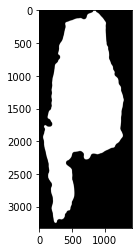

In [10]:
# morphological fill
fix_dat.Fill()
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

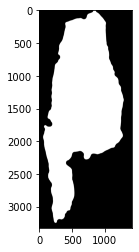

In [11]:
# morphological opening
fix_dat.Open(disk_size=15,parallel=False)
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

Now that we are happy with how the mask looks, we will ensure that no regions are captured as foreground that are outside of our manually drawn mask that was imported at the beginning of the notebook along with the prototype-001 dataset.

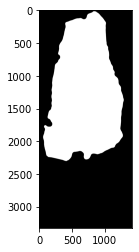

In [12]:
# apply the manual input mask (will act on the previous masks)
fix_dat.ApplyManualMask()
# extract the processed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

Once we are ready to start exporting the processed region, we will apply the `NonzeroBox` function to create a bounding box around our mask. This ensures that the image is centered in our field of view, so that we can add the necessary padding on the edges of the image to ensure a good image registration process.

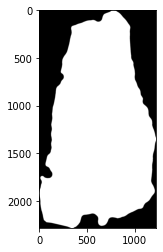

In [13]:
# extract bounding box in the image for constant padding
fix_dat.NonzeroBox()
# extract the procesed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image.toarray(),cmap='gray')

Now, we will apply the processed mask to the original image using the `ApplyMask` function. Since we set `save_mem=False` in our import step, the original image is always going to be stored in the `IntraModalityDataset` class object.

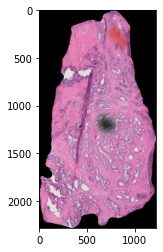

In [14]:
# apply the final mask after all operations
fix_dat.ApplyMask()
# extract the procesed image to show
plt.imshow(fix_dat.set_dict[key].hdi.data.processed_image)

We will now add padding to the edges of the image to register this image to our mass spectrometry imaging data set. We recommend being a little generous with how much padding you add -- leaving too little room on the edges of your image may make the registration optimization more difficult.

We will export the image with padding and read it back into our session to view the results:

In [15]:
# export the processed image to the nifti format for image registration
# here we pad the image for registration with the corresponding MSI
# compressed image.
fix_dat.ExportNifti1(
                    output_dir=out_path,
                    padding="(150,150)",
                    target_size=None
                    )

Exporting nifti image stack...
Finished exporting /Users/joshuahess/Desktop/prototype-001/notebook-output/fixed_processed.nii


Valid path...
Valid file extension... 
file name: /Users/joshuahess/Desktop/prototype-001/notebook-output/fixed_processed.nii 
parsing nifti...
Finished parsing nifti
Finished


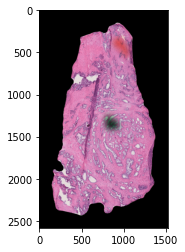

In [16]:
# load the exported image and view
exported = hdi_reader.HDIreader(
                    path_to_data=os.path.join(out_path,"fixed_processed.nii"),
                    path_to_markers=None,
                    flatten=False,
                    subsample=None,
                    mask=None,
                    save_mem=False
                    )
# plot the exported image
plt.imshow(exported.hdi.data.image)